In [2]:
import numpy as np
import os
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
import glob
#from sklearn.metrics import mean_squared_error

In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/michellegarcia2000/p-rotein/main/all_data_1.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/michellegarcia2000/p-rotein/main/all_data_2.csv")
df = pd.concat([df1,df2])
df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True) # replace spaces with _


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
disordered = df.loc[df["label"]==1.0]
label_dis = disordered["label"]
disordered = disordered.drop(columns=["label", "sequence"])
ordered = df.loc[df["label"]==0.0]
label_ord = ordered["label"]
ordered = ordered.drop(columns=["label", "sequence"])

# 16316 disordered => 0.236 
# 240481 ordered 
# 7704 => 3852 => 3% total 
#split ordered
xo_train, xo_test, yo_train, yo_test = train_test_split(disordered, label_dis, test_size=0.236, random_state=42)
#split disordered
xd_train, xd_test, yd_train, yd_test = train_test_split(ordered, label_ord, test_size=0.016, random_state=42)
#concatenate the two
train_features = pd.concat([xo_train, xd_train])
train_labels = pd.concat([yo_train, yd_train])

test_features = pd.concat([xo_test, xd_test])
test_labels = pd.concat([yo_test, yd_test])

In [6]:
train_features.head()

,seq_len,molecular_weight,hydrophobicity,instability_index,aromaticity,A_%,C_%,D_%,E_%,F_%,...,M_%,N_%,P_%,Q_%,R_%,S_%,T_%,V_%,W_%,Y_%
121996,124,13690.1785,-0.662903,42.120968,0.072581,0.096774,0.064516,0.040323,0.040323,0.024194,...,0.032258,0.080645,0.032258,0.056452,0.032258,0.120968,0.080645,0.072581,0.000000,0.048387
117483,150,17455.0538,-0.310000,41.368667,0.100000,0.033333,0.093333,0.086667,0.060000,0.026667,...,0.020000,0.020000,0.026667,0.046667,0.080000,0.040000,0.020000,0.046667,0.013333,0.060000
119833,873,100199.3530,-0.547766,39.261982,0.098511,0.046964,0.003436,0.059565,0.075601,0.049255,...,0.016037,0.033219,0.043528,0.050401,0.046964,0.084765,0.076747,0.053837,0.006873,0.042383
119351,245,25665.8377,0.051020,15.271429,0.073469,0.089796,0.040816,0.036735,0.020408,0.024490,...,0.008163,0.057143,0.036735,0.040816,0.016327,0.114286,0.093878,0.093878,0.032653,0.016327
123311,1015,118417.5854,-1.128670,46.432975,0.094581,0.012808,0.016749,0.082759,0.051232,0.033498,...,0.015764,0.228571,0.029557,0.023645,0.022660,0.062069,0.038424,0.043350,0.007882,0.053202


In [7]:
#X, y = df.iloc[:,1:-1],df.iloc[:,-1]
train_features["seq_len"].astype("category")
train_features["molecular_weight"].astype("category")
train_features["hydrophobicity"].astype("category")
train_features["instability_index"].astype("category")
train_features["aromaticity"].astype("category")
data_dmatrix = xgb.DMatrix(data=train_features,label=train_labels)

In [8]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = xgb.XGBClassifier(tree_method="gpu_hist", enable_categorical=True, scale_pos_weight=22)
clf

XGBClassifier(enable_categorical=True, scale_pos_weight=22,
              tree_method='gpu_hist')

In [9]:
# X is the dataframe we created in previous snippet
clf.fit(train_features, train_labels)
xgpredict = clf.predict(test_features)
xgpredict


array([1, 1, 0, ..., 1, 0, 0])

In [10]:
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
clf.save_model("categorical-model.json")

In [13]:
# Get a graph
graph = xgb.to_graphviz(clf, num_trees=2)
# Or get a matplotlib axis
ax = xgb.plot_tree(clf, num_trees=2)
plt.rcParams["figure.figsize"]=(300,500)
plt.show(ax)
#f = open(os.path.expanduser("~Doc1.txt"),"w")
#f.write(ax)
#f.close()
# Get feature importances
clf.feature_importances_


array([0.02061097, 0.04273153, 0.03509367, 0.02683163, 0.01964319,
       0.11699077, 0.02139414, 0.03136973, 0.03090771, 0.01732856,
       0.02614121, 0.02024711, 0.03336672, 0.02893955, 0.01211821,
       0.03196307, 0.29410222, 0.02007228, 0.00763215, 0.0287508 ,
       0.04804295, 0.01590664, 0.02664448, 0.02641566, 0.01675498],
      dtype=float32)

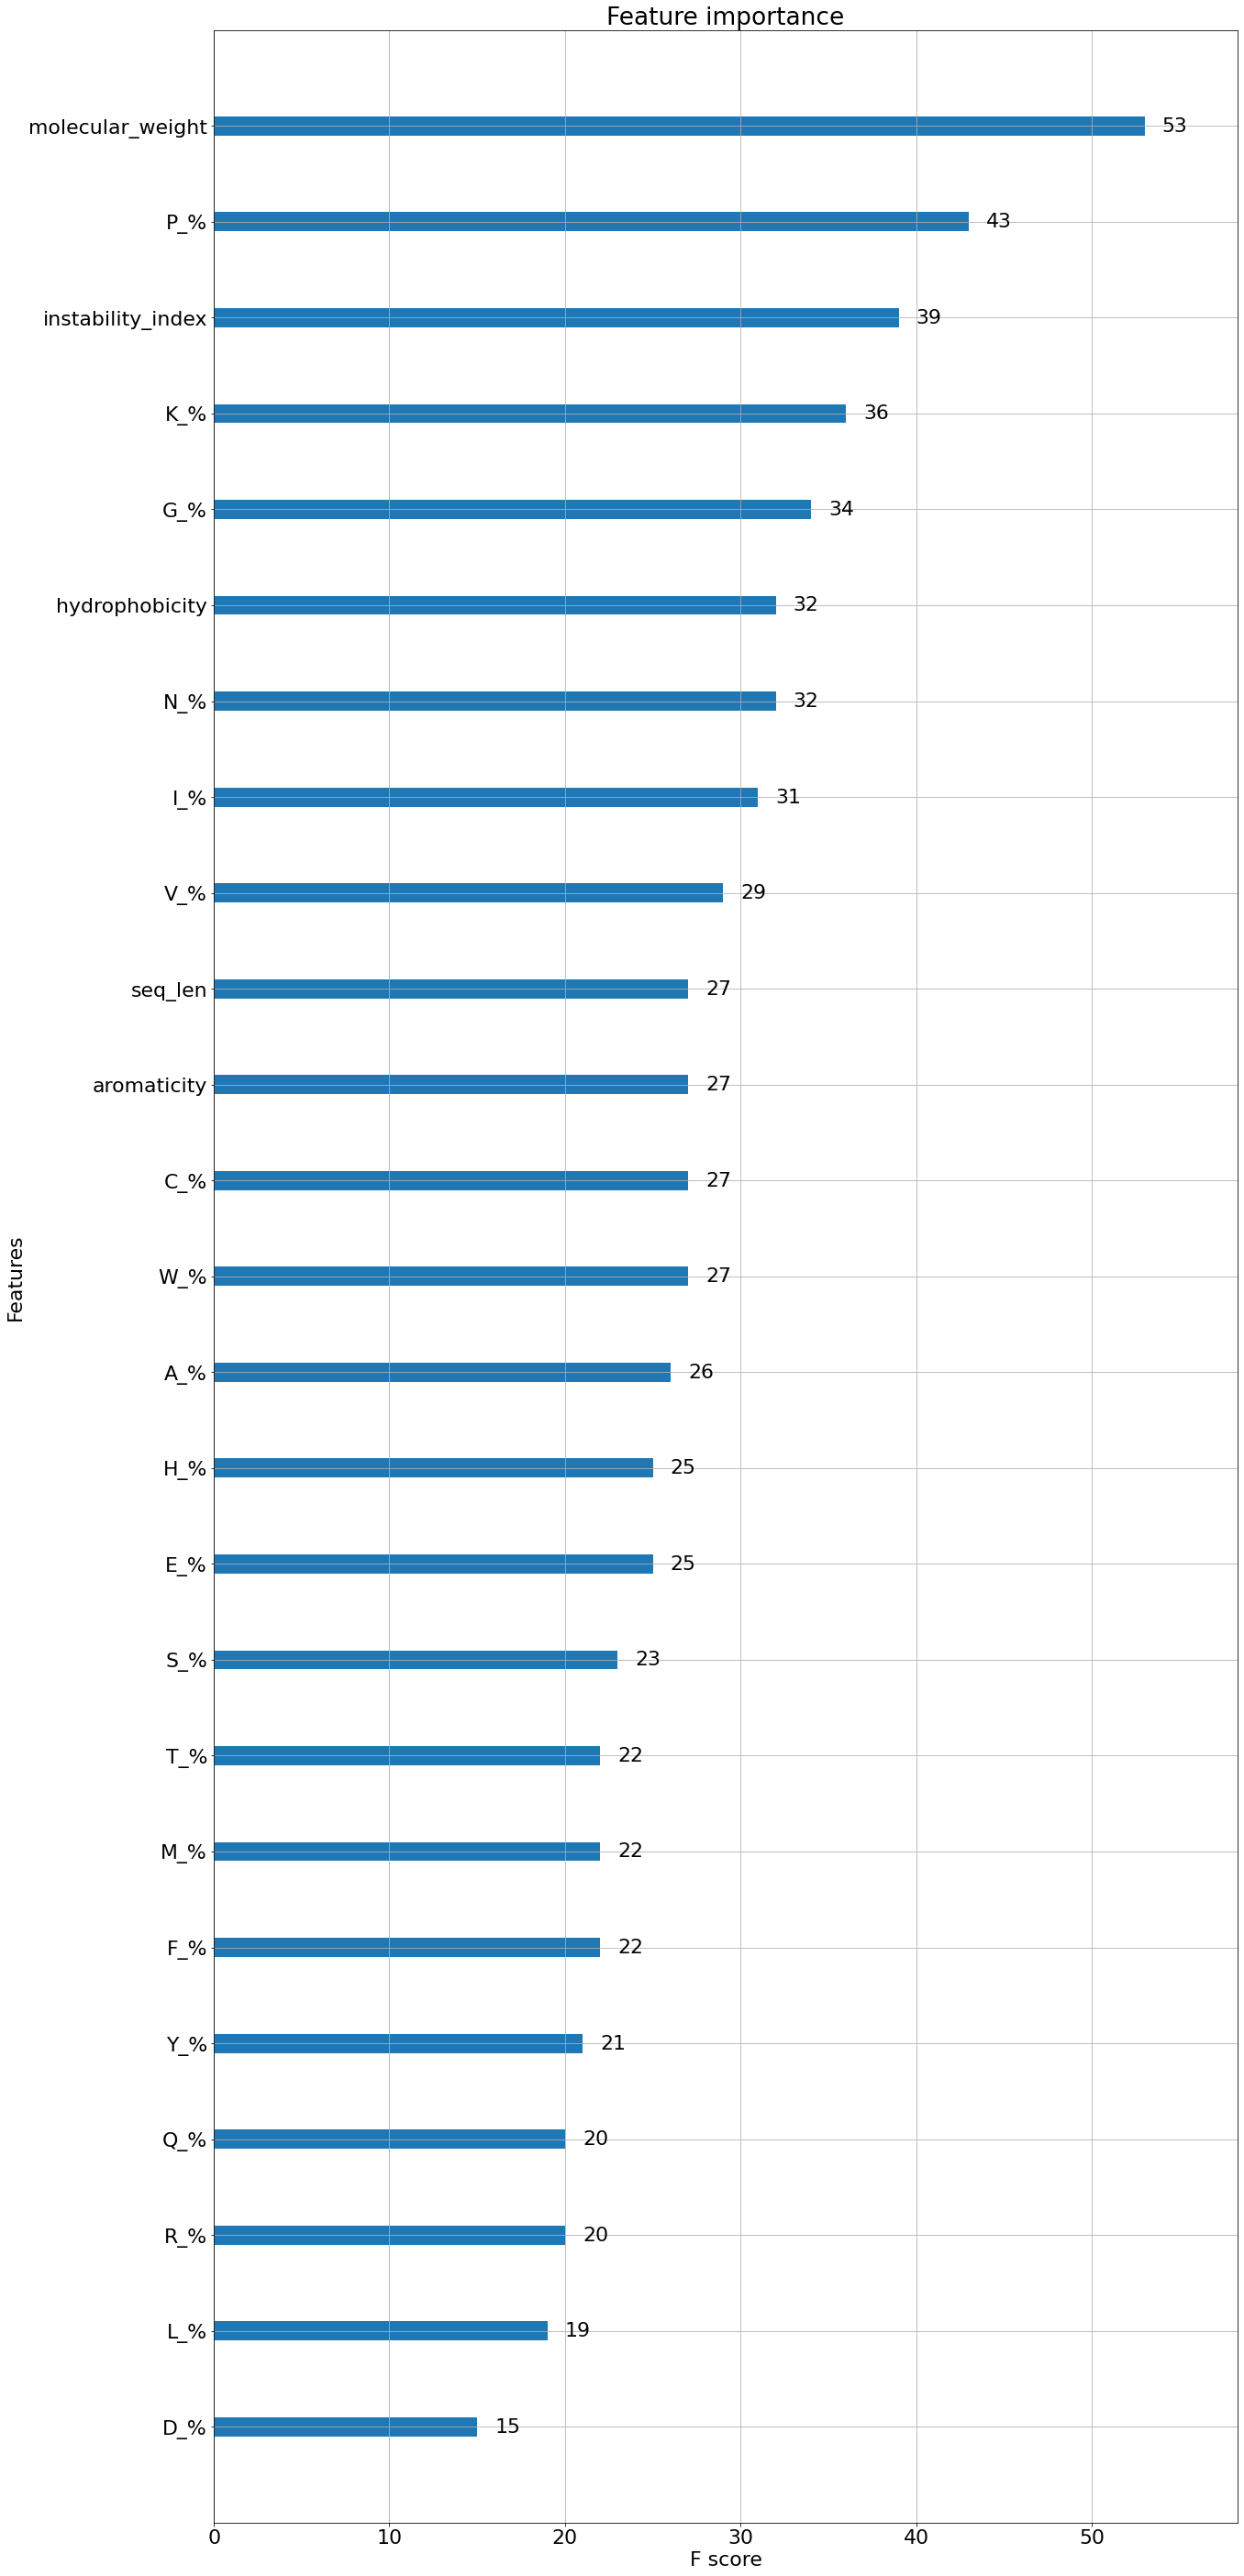

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
newplot = plot_importance(clf)
plt.rcParams["figure.figsize"]=(10,30)
plt.rcParams.update({'font.size':35})
plt.show(newplot)

In [ ]:
## confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_labels,xgpredict))
print(classification_report(test_labels,xgpredict))

[[3101  747]
 [1362 2489]]
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      3848
           1       0.77      0.65      0.70      3851

    accuracy                           0.73      7699
   macro avg       0.73      0.73      0.72      7699
weighted avg       0.73      0.73      0.72      7699

